GOLD-PRICE PREDICTION USING TIME-SERIES FORECASTING:


Import Libraries:

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from typing import Union
from itertools import product
from tqdm.notebook import tqdm_notebook
# !pip install statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.gofplots import qqplot
import statsmodels.api as sm
import matplotlib.dates as mdates
from sklearn.metrics import mean_squared_error
import math
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU
from math import sqrt

Loading and Cleaning of Data to prepare for Forecasting

In [ ]:
data = pd.read_csv('/content/Gold Price.csv')
print(data.head())

         Date  Price   Open   High    Low  Volume  Chg%
0  2024-11-06  77030  78300  78570  77030       0 -1.86
1  2024-11-05  78490  78224  78670  78160       0  0.11
2  2024-11-04  78401  78498  78642  78237       0 -0.54
3  2024-11-01  78829  78650  78887  78550       0  0.64
4  2024-10-31  78326  79264  79999  77803      90 -1.17


In [ ]:
print(data.isnull().sum())

data = data.dropna()

print(data.isnull().sum())

Date      0
Price     0
Open      0
High      0
Low       0
Volume    0
Chg%      0
dtype: int64
Date      0
Price     0
Open      0
High      0
Low       0
Volume    0
Chg%      0
dtype: int64


In [ ]:
data.describe()

,Price,Open,High,Low,Volume,Chg%
count,2806.000000,2806.000000,2806.000000,2806.000000,2806.000000,2806.000000
mean,40699.885959,40700.218460,40917.777976,40482.312901,12529.581611,0.037758
std,13828.621023,13826.938709,13900.465881,13756.094789,10649.994389,0.828591
min,24545.000000,24583.000000,24635.000000,24470.000000,0.000000,-5.980000
25%,29128.000000,29103.750000,29261.250000,28974.000000,6282.500000,-0.380000
50%,32980.000000,33000.000000,33220.500000,32890.000000,10770.000000,0.040000
75%,50613.500000,50646.750000,50911.250000,50337.500000,16397.500000,0.450000
max,79257.000000,79264.000000,79999.000000,78888.000000,106920.000000,5.300000


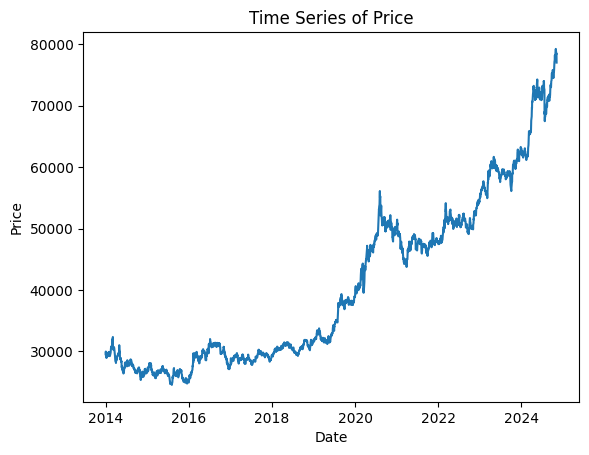

In [ ]:
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')

plt.plot(data['Price'])
plt.title(f'Time Series of Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

Decomposition of Data into Tread, Seasonality and Residuals


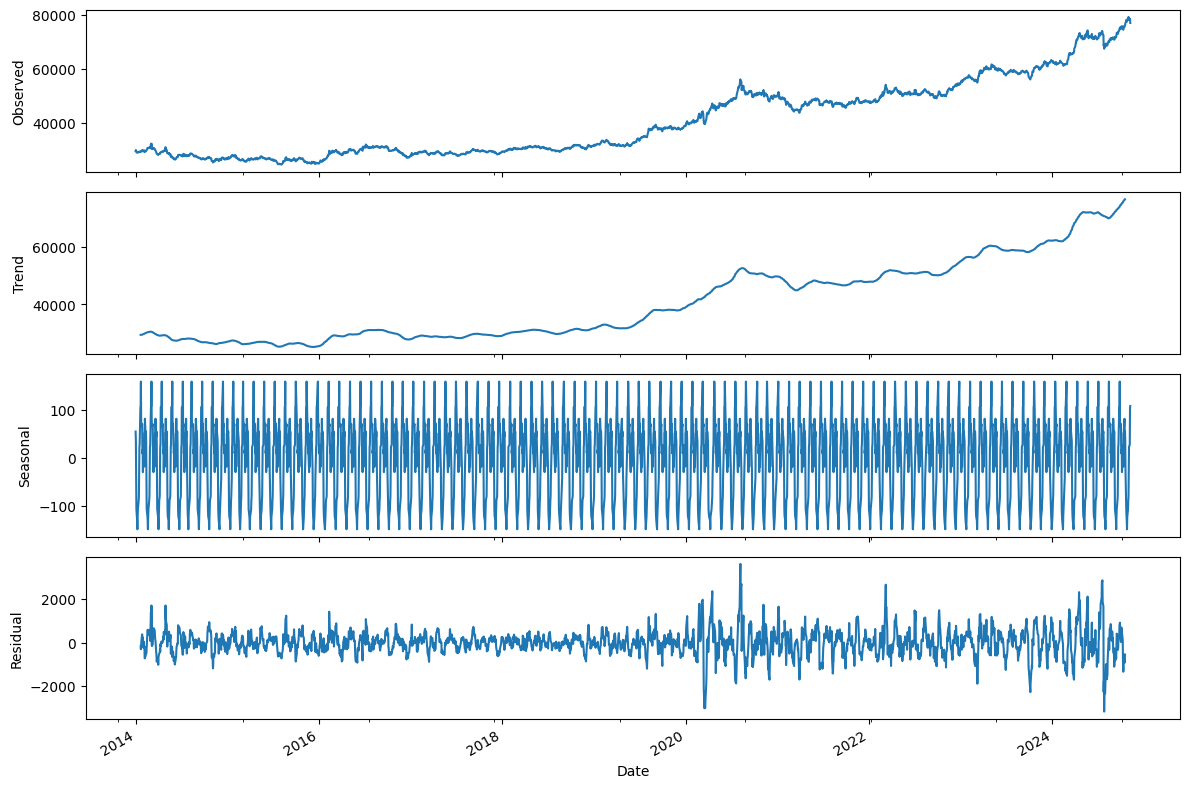

In [ ]:
decomposition = seasonal_decompose(data['Price'], model='additive', period=30)

fig, axes = plt.subplots(4, 1, sharex=True, figsize=(12, 8))


decomposition.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observed')


decomposition.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend')

decomposition.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')

decomposition.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residual')


plt.tight_layout()
plt.show()


Check for Stationarity:

In [ ]:
result = adfuller(data['Price'], regression='ct')

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

if result[1] <= 0.05:
    print("The time series is likely stationary (reject H0).")
else:
    print("The time series is likely non-stationary (fail to reject H0).")


ADF Statistic: -2.166764
p-value: 0.508568
The time series is likely non-stationary (fail to reject H0).


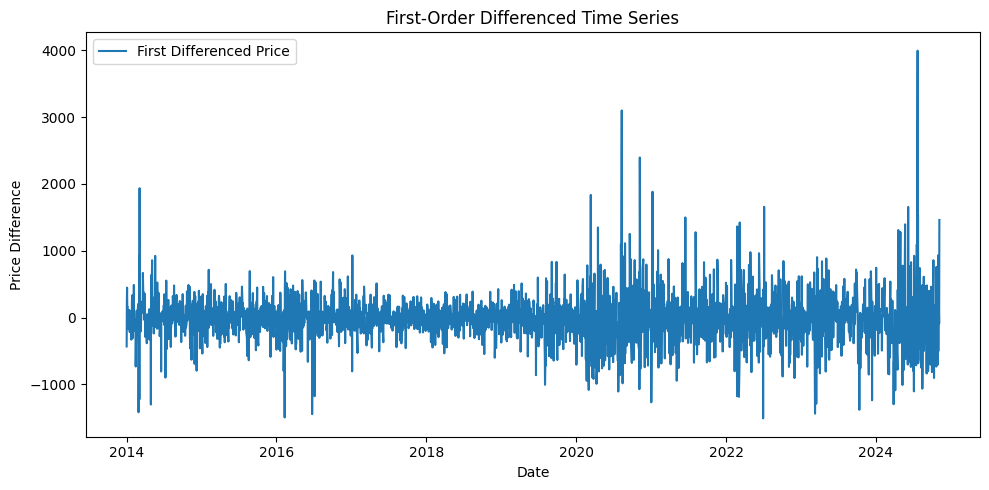

In [ ]:
data['Price_diff'] = data['Price'].diff()
data_diff = data.dropna()

plt.figure(figsize=(10, 5))
plt.plot(data_diff.index, data_diff['Price_diff'], label='First Differenced Price')

plt.title('First-Order Differenced Time Series')
plt.xlabel('Date')
plt.ylabel('Price Difference')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
result = adfuller(data_diff['Price_diff'], regression='c')

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

if result[1] <= 0.05:
    print("The time series is likely stationary (reject H0).")
else:
    print("The time series is likely non-stationary (fail to reject H0).")

ADF Statistic: -15.191577
p-value: 0.000000
The time series is likely stationary (reject H0).


Training data shape: (2587, 7)
Testing data shape: (219, 7)


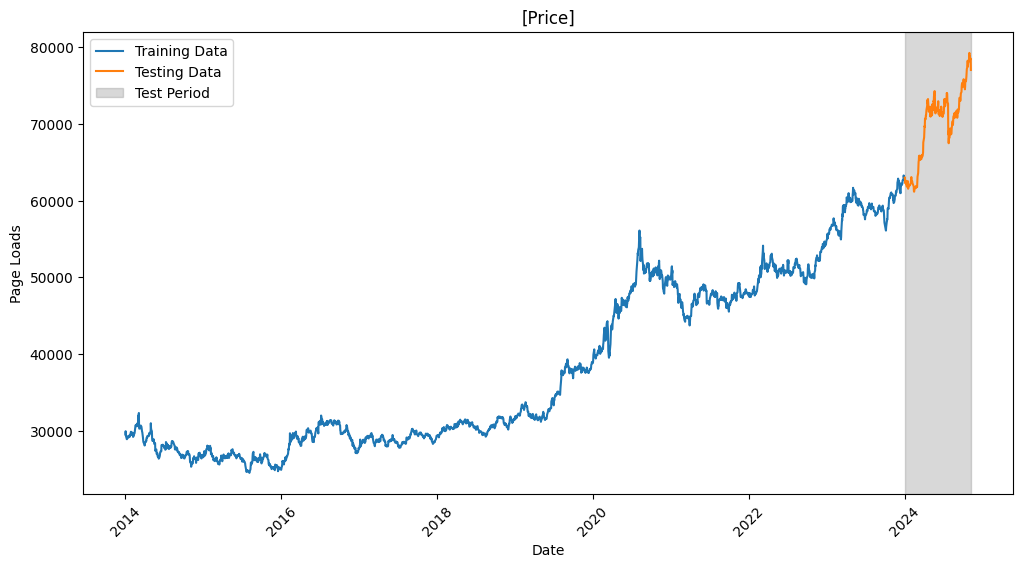

In [ ]:
train_data = data[data.index.year < 2024]
test_data = data[data.index.year >= 2024]

print("Training data shape:", train_data.shape)
print("Testing data shape:", test_data.shape)

plt.figure(figsize=(12, 6))

plt.plot(train_data.index, train_data['Price'], label='Training Data')
plt.plot(test_data.index, test_data['Price'], label='Testing Data')
plt.axvspan(test_data.index.min(), test_data.index.max(), color='gray', alpha=0.3, label='Test Period')
plt.xlabel('Date')
plt.ylabel('Page Loads')
plt.title('[Price]')
plt.xticks(rotation=45)
plt.legend()
plt.show()

Training data shape: (2587, 7)
Testing data shape: (219, 7)


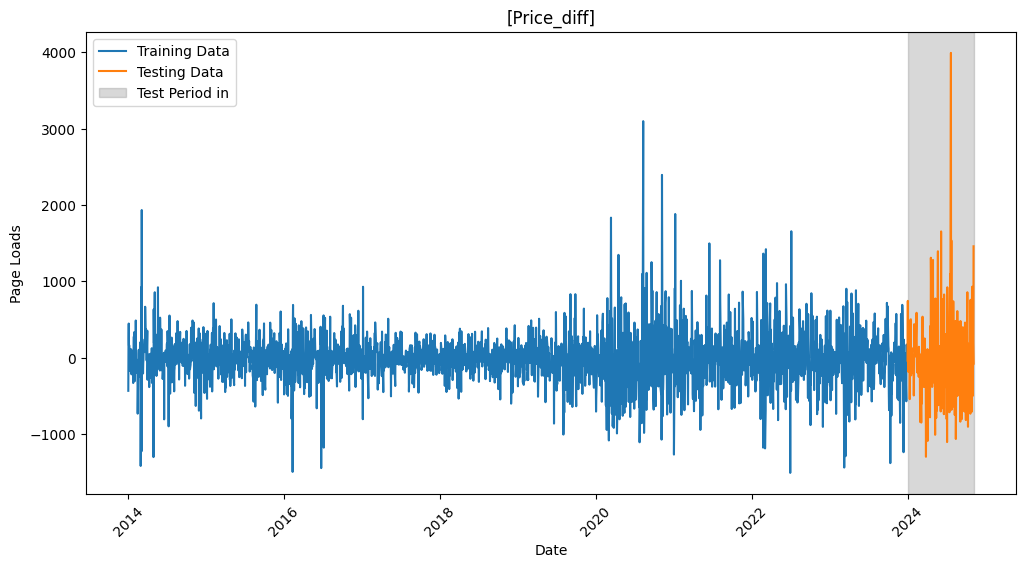

In [ ]:
train_data_st = data[data.index.year < 2024]
test_data_st = data[data.index.year >= 2024]

print("Training data shape:", train_data.shape)
print("Testing data shape:", test_data.shape)

plt.figure(figsize=(12, 6))
plt.plot(train_data_st.index, train_data_st['Price_diff'], label='Training Data')
plt.plot(test_data_st.index, test_data_st['Price_diff'], label='Testing Data')
plt.axvspan(test_data_st.index.min(), test_data_st.index.max(), color='gray', alpha=0.3, label='Test Period in')
plt.xlabel('Date')
plt.ylabel('Page Loads')
plt.title('[Price_diff]')
plt.xticks(rotation=45)
plt.legend()
plt.show()

BASELINE MODELS

1. MEAN

2. MEAN of last 30

3. NAIVE SEASONAL

Mean of the training data: 38232.58484731349


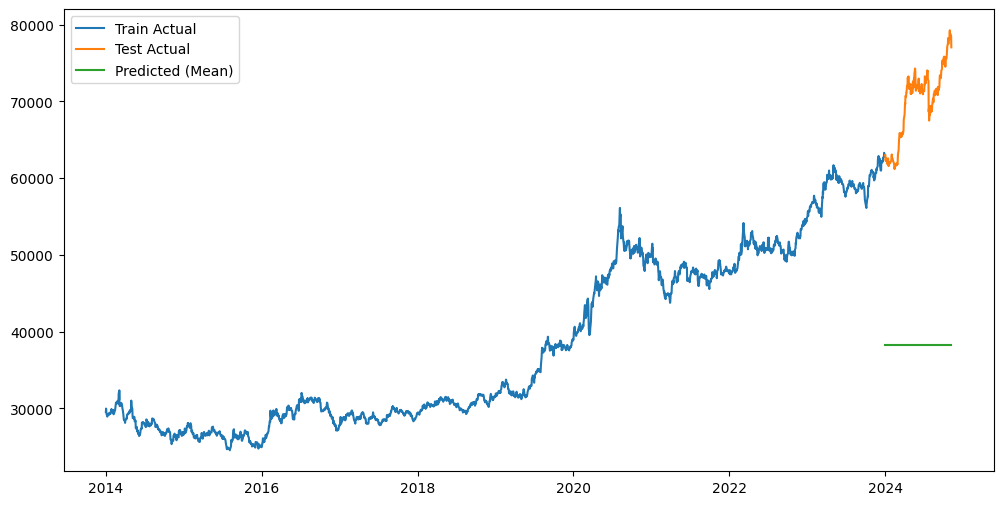

RMSE for Mean Method: 31979.19411740937


In [ ]:
#mean

print("Mean of the training data:", train_data['Price'].mean())

ypred = [train_data['Price'].mean()] * len(test_data)
plt.figure(figsize=(12,6))
plt.plot(train_data.index, train_data['Price'], label='Train Actual')
plt.plot(test_data.index, test_data['Price'], label='Test Actual')
plt.plot(test_data.index, ypred, label='Predicted (Mean)')
plt.legend()
plt.show()

rmse_mean = math.sqrt(mean_squared_error(test_data['Price'], ypred))
print(f"RMSE for Mean Method: {rmse_mean}")

Mean of the last 30 values in the training data: 29411.0


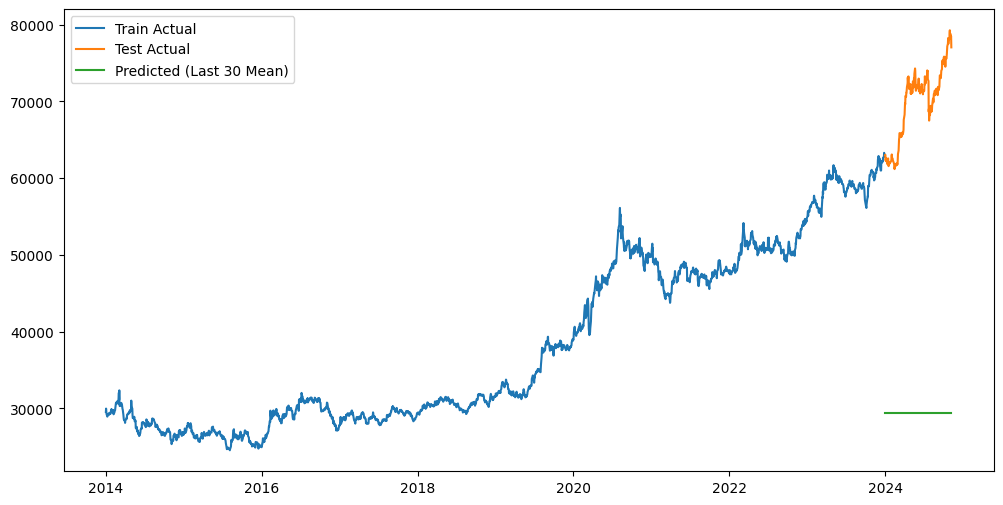

RMSE for Last 30 Mean Method: 40721.52664872401


In [ ]:
# Calculate the mean of the last 30 values in the training data

print("Mean of the last 30 values in the training data:", train_data['Price'].tail(30).mean())

last_five_mean = train_data['Price'].tail(30).mean()
ypred_last_five = [last_five_mean] * len(test_data)

plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['Price'], label='Train Actual')
plt.plot(test_data.index, test_data['Price'], label='Test Actual')
plt.plot(test_data.index, ypred_last_five, label='Predicted (Last 30 Mean)')
plt.legend()
plt.show()

rmse_last_30 = math.sqrt(mean_squared_error(test_data['Price'], ypred_last_five))
print(f"RMSE for Last 30 Mean Method: {rmse_last_30}")


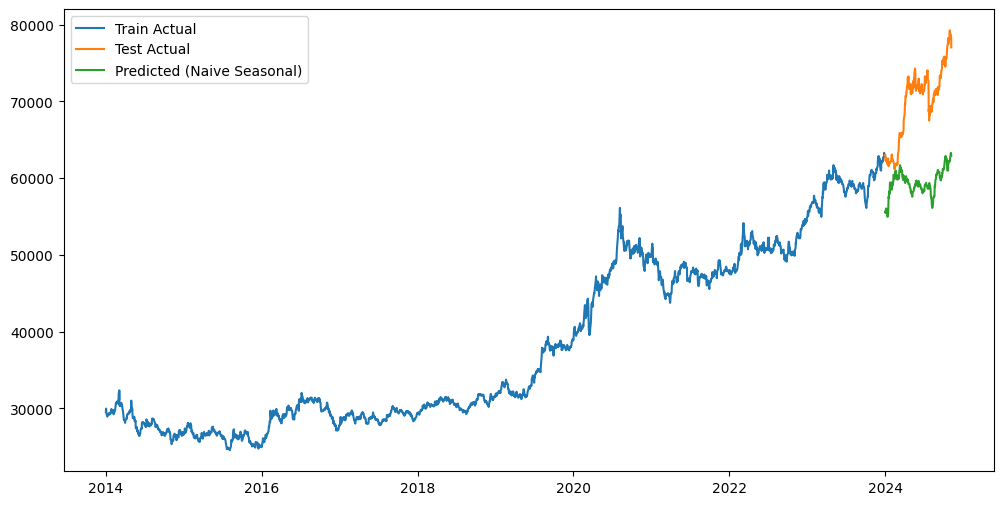

RMSE for Naive Seasonal Method: 11270.451185597702


In [ ]:
# Naive Seasonal Method
ytest_naive_seasonal = train_data['Price'].iloc[:len(test_data)]


plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['Price'], label='Train Actual')
plt.plot(test_data.index, test_data['Price'], label='Test Actual')
plt.plot(test_data.index, ytest_naive_seasonal, label='Predicted (Naive Seasonal)')
plt.legend()
plt.show()

rmse_naive_seasonal = math.sqrt(mean_squared_error(test_data['Price'], ytest_naive_seasonal))
print(f"RMSE for Naive Seasonal Method: {rmse_naive_seasonal}")

In [ ]:
rmse_df = pd.DataFrame({
    'Model': ['Mean', 'Last 30 Mean', 'Naive Seasonal'],
    'RMSE': [rmse_mean, rmse_last_30, rmse_naive_seasonal]
})

rmse_df

,Model,RMSE
0,Mean,31979.194117
1,Last 30 Mean,40721.526649
2,Naive Seasonal,11270.451186


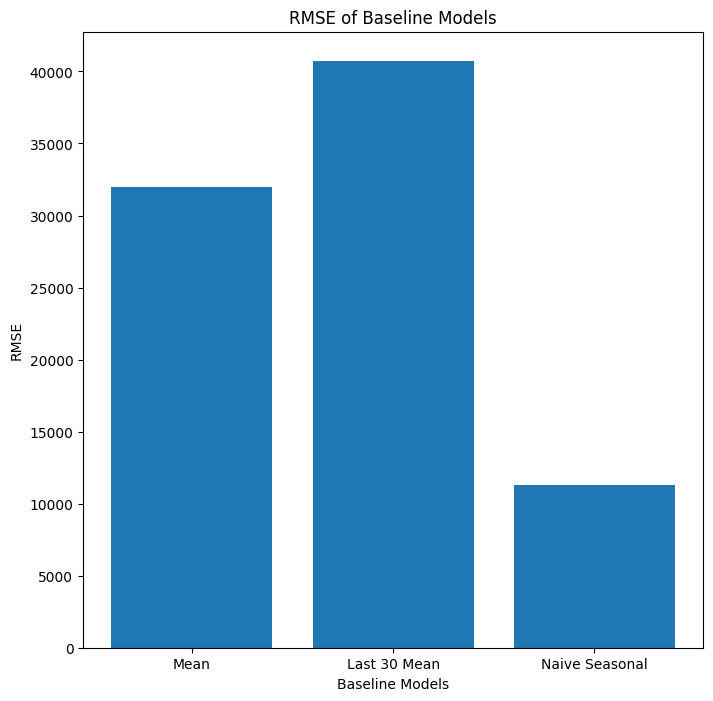

In [ ]:
#-------------------BAR GRAPH------------------

models = ['Mean', 'Last 30 Mean', 'Naive Seasonal']
rmse_values = [rmse_mean, rmse_last_30, rmse_naive_seasonal]

plt.figure(figsize=(8, 8))
plt.bar(models, rmse_values)
plt.xlabel("Baseline Models")
plt.ylabel("RMSE")
plt.title("RMSE of Baseline Models")
plt.show()

Apply Models and which one is better for this time series

1 - MA

2 - AR

3 - ARMA

4 - ARIMA

5 - SARIMA


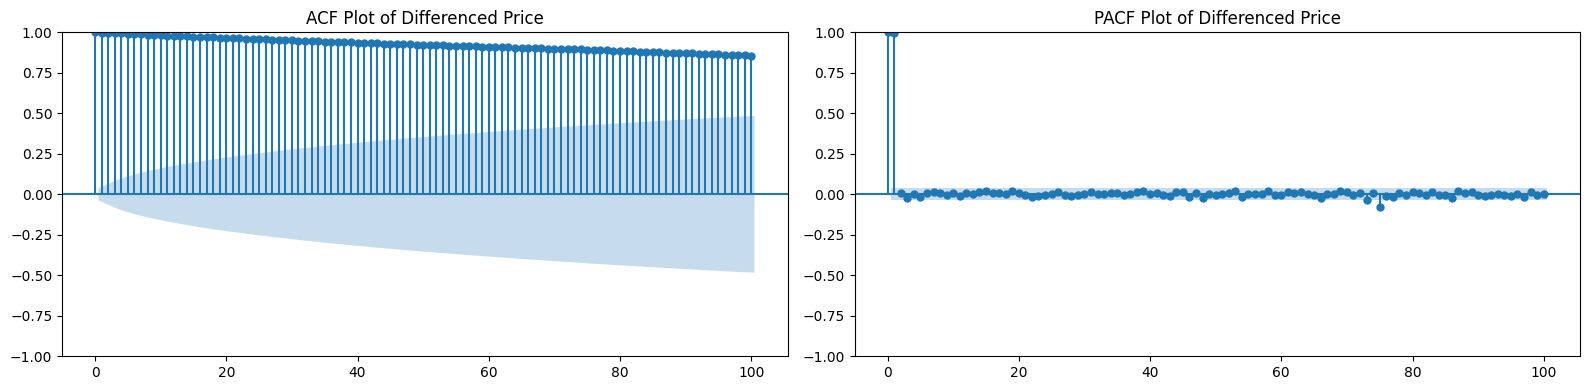

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

plot_acf(data_diff['Price'].dropna(), lags=100, ax=axes[0])
axes[0].set_title('ACF Plot of Differenced Price')

plot_pacf(data_diff['Price'].dropna(), lags=100, ax=axes[1])
axes[1].set_title('PACF Plot of Differenced Price')

plt.tight_layout()
plt.show()


PACF cuts off (sharp drop) after lag 2

ACF tails off gradually

according to this Auto-correlation graph AR(2) model is best for forcasting next values.

In [ ]:
#AR Model

ps_ar = range(0, 6, 1)
order_list_ar = [(p, 0) for p in ps_ar]

print(order_list_ar)

def optimize_AR(endog: pd.Series, order_list: list) -> pd.DataFrame:

    results = []

    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(endog, order=(order[0], 0, 0), simple_differencing=False).fit(disp=False)
            aic = model.aic
            results.append([order, aic])
        except Exception as e:
            print(f"Error with order {order}: {e}")
            continue

    if results:
        result_df = pd.DataFrame(results)
        result_df.columns = ['(p)', 'AIC']
        result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

        best_order = result_df.iloc[0, 0]
        best_model = SARIMAX(endog, order=(best_order[0], 0, 0), simple_differencing=False).fit(disp=False)

        return result_df, best_model

    else:
        print("No successful model fitting.")
        return None

result_ar, best_ar_model = optimize_AR(train_data_st['Price_diff'], order_list_ar)
result_ar

[(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0)]


  0%|          | 0/6 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsm

,(p),AIC
0,"(2, 0)",37329.127449
1,"(3, 0)",37329.434300
2,"(1, 0)",37330.182762
3,"(4, 0)",37331.177664
4,"(0, 0)",37331.837800
5,"(5, 0)",37333.162165


In [ ]:
qs_ma = range(0, 6, 1)

order_list_ma = [(0, q) for q in qs_ma]

print(order_list_ma)

def optimize_MA(endog: pd.Series, order_list: list) -> pd.DataFrame:
    results = []

    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(endog, order=(0, 0, order[1]), simple_differencing=False).fit(disp=False)
            aic = model.aic
            results.append([order, aic])
        except Exception as e:
            print(f"Error with order {order}: {e}")
            continue

    if results:
        result_df = pd.DataFrame(results)
        result_df.columns = ['(q)', 'AIC']
        result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

        best_order = result_df.iloc[0, 0]
        best_model = SARIMAX(endog, order=(0, 0, best_order[1]), simple_differencing=False).fit(disp=False)

        return result_df, best_model

    else:
        print("No successful model fitting.")
        return None

result_ma, best_ma_model = optimize_MA(train_data_st['Price_diff'], order_list_ma)

result_ma


[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5)]


  0%|          | 0/6 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsm

,(q),AIC
0,"(0, 2)",37328.739201
1,"(0, 3)",37329.350090
2,"(0, 1)",37330.427368
3,"(0, 4)",37331.297587
4,"(0, 0)",37331.837800
5,"(0, 5)",37333.294871


In [ ]:
#ARMA model

ps_arma = range(0, 6, 1)
qs_arma = range(0, 6, 1)

order_list_arma = list(product(ps_arma, qs_arma))
print(order_list_arma)

def optimize_ARMA(endog: Union[pd.Series, list], order_list: list) -> pd.DataFrame:

    results = []

    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(endog, order=(order[0], 0, order[1]), simple_differencing=False).fit(disp=False)
            aic = model.aic
            results.append([order, aic])
        except Exception as e:
            print(f"Error with order {order}: {e}")
            continue


    if results:
        result_df = pd.DataFrame(results)
        result_df.columns = ['(p,q)', 'AIC']
        result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

        best_order = result_df.iloc[0,0]

        best_model = SARIMAX(endog, order=(best_order[0], 0, best_order[1]), simple_differencing=False).fit(disp=False) #Fit the model

        return result_df,best_model

    else:
        print("No successful model fitting.")
        return None


result_arma, best_arma_model = optimize_ARMA(train_data_st['Price_diff'], order_list_arma)
result_arma

[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5)]


  0%|          | 0/36 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsm

,"(p,q)",AIC
0,"(4, 4)",37314.950270
1,"(4, 5)",37317.263193
2,"(5, 4)",37317.931938
3,"(5, 5)",37317.998696
4,"(2, 5)",37321.071940
5,"(3, 5)",37322.533848
6,"(3, 2)",37322.832220
7,"(2, 2)",37323.244585
8,"(3, 4)",37324.562943
9,"(2, 4)",37324.749588


In [ ]:
#ARIMA model

ps_arma = range(0, 6, 1)
qs_arma = range(0, 6, 1)
d=1

order_list_arima = list(product(ps_arma, qs_arma))
print(order_list_arima)

def optimize_ARIMA(endog: Union[pd.Series, list], order_list: list) -> pd.DataFrame:

    results = []

    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(endog, order=(order[0], d, order[1]), simple_differencing=False).fit(disp=False)
            aic = model.aic
            results.append([order, aic])
        except Exception as e:
            print(f"Error with order {order}: {e}")
            continue


    if results:
        result_df = pd.DataFrame(results)
        result_df.columns = ['(p,q)', 'AIC']
        result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

        best_order = result_df.iloc[0,0]

        best_model = SARIMAX(endog, order=(best_order[0], 0, best_order[1]), simple_differencing=False).fit(disp=False) #Fit the model

        return result_df,best_model

    else:
        print("No successful model fitting.")
        return None


result_arma, best_arima_model = optimize_ARIMA(train_data['Price'], order_list_arma)
result_arma

[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5)]


  0%|          | 0/36 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsm

,"(p,q)",AIC
0,"(4, 4)",37307.335265
1,"(4, 5)",37309.295188
2,"(5, 4)",37309.486493
3,"(5, 5)",37309.941133
4,"(2, 5)",37310.618255
5,"(3, 4)",37312.648775
6,"(3, 5)",37314.482954
7,"(2, 2)",37315.071494
8,"(0, 2)",37316.224145
9,"(2, 4)",37316.375717


In [ ]:
#SARIMA
from itertools import product

ps_sarima = range(0, 3, 1)
qs_sarima = range(0, 3, 1)
Ps_sarima = range(0, 2, 1)
Qs_sarima = range(0, 2, 1)
D=1
d=1

order_list_sarima = list(product(ps_sarima, qs_sarima, Ps_sarima, Qs_sarima))
print(order_list_sarima)

def optimize_SARIMA(endog: Union[pd.Series, list], order_list: list) -> pd.DataFrame:

    results = []

    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(endog, order=(order[0], d, order[1]), seasonal_order=(order[2], D, order[3], 30), simple_differencing=False).fit(disp=False)
            aic = model.aic
            results.append([order, aic])
        except Exception as e:
            print(f"Error with order {order}: {e}")
            continue


    if results:
        result_df = pd.DataFrame(results)
        result_df.columns = ['(p,q,P,Q)', 'AIC']
        result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

        best_order = result_df.iloc[0,0]

        best_model = SARIMAX(endog, order=(best_order[0], d, best_order[1]), seasonal_order=(best_order[2], D, best_order[3], 30), simple_differencing=False).fit(disp=False) #Fit the model

        return result_df,best_model

    else:
        print("No successful model fitting.")
        return None


result_sarima, best_sarima_model = optimize_SARIMA(train_data['Price'], order_list_sarima)
result_sarima

[(0, 0, 0, 0), (0, 0, 0, 1), (0, 0, 1, 0), (0, 0, 1, 1), (0, 1, 0, 0), (0, 1, 0, 1), (0, 1, 1, 0), (0, 1, 1, 1), (0, 2, 0, 0), (0, 2, 0, 1), (0, 2, 1, 0), (0, 2, 1, 1), (1, 0, 0, 0), (1, 0, 0, 1), (1, 0, 1, 0), (1, 0, 1, 1), (1, 1, 0, 0), (1, 1, 0, 1), (1, 1, 1, 0), (1, 1, 1, 1), (1, 2, 0, 0), (1, 2, 0, 1), (1, 2, 1, 0), (1, 2, 1, 1), (2, 0, 0, 0), (2, 0, 0, 1), (2, 0, 1, 0), (2, 0, 1, 1), (2, 1, 0, 0), (2, 1, 0, 1), (2, 1, 1, 0), (2, 1, 1, 1), (2, 2, 0, 0), (2, 2, 0, 1), (2, 2, 1, 0), (2, 2, 1, 1)]


  0%|          | 0/36 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsm

,"(p,q,P,Q)",AIC
0,"(1, 0, 1, 1)",37257.251467
1,"(0, 2, 1, 1)",37257.358804
2,"(0, 1, 1, 1)",37257.418838
3,"(2, 0, 1, 1)",37257.471017
4,"(0, 0, 1, 1)",37258.819099
5,"(2, 1, 1, 1)",37261.172638
6,"(1, 2, 1, 1)",37261.399167
7,"(2, 2, 1, 1)",37262.039263
8,"(1, 1, 1, 1)",37262.818079
9,"(0, 2, 0, 1)",37281.244805


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-pa

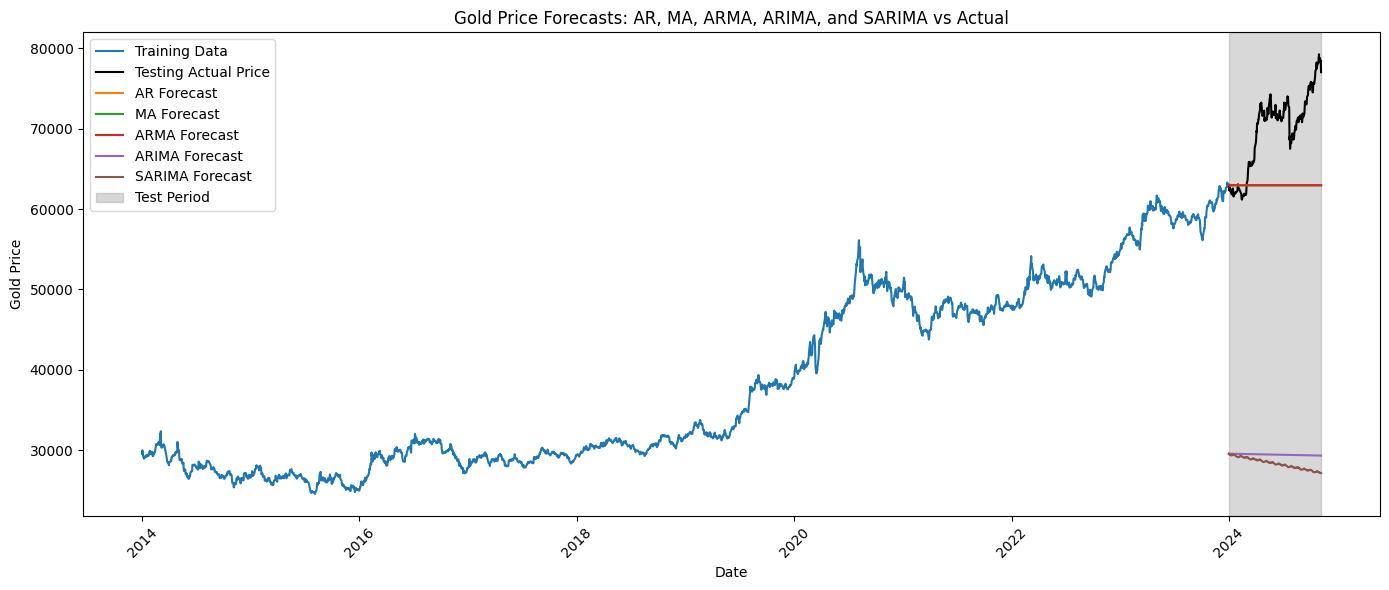

In [ ]:
# Step 1: Sort datasets (already done by you)
train_data_st = train_data_st.sort_values('Date')
test_data_st = test_data_st.sort_values('Date')
train_data = train_data.sort_values('Date')
test_data = test_data.sort_values('Date')

ar_pred = best_ar_model.predict(start=len(train_data_st), end=len(train_data_st) + len(test_data_st) - 1)
ma_pred = best_ma_model.predict(start=len(train_data_st), end=len(train_data_st) + len(test_data_st) - 1)
arma_pred = best_arma_model.predict(start=len(train_data_st), end=len(train_data_st) + len(test_data_st) - 1)

last_train_price = train_data['Price'].iloc[-1]

ar_pred_orig = ar_pred.cumsum() + last_train_price
ma_pred_orig = ma_pred.cumsum() + last_train_price
arma_pred_orig = arma_pred.cumsum() + last_train_price

arima_forecast = best_arima_model.get_forecast(steps=len(test_data))
sarima_forecast = best_sarima_model.get_forecast(steps=len(test_data))


plt.figure(figsize=(14, 6))
plt.plot(train_data.index, train_data['Price'], label='Training Data')
plt.plot(test_data.index, test_data['Price'], label='Testing Actual Price', color='black')
plt.plot(test_data.index, ar_pred_orig, label='AR Forecast')
plt.plot(test_data.index, ma_pred_orig, label='MA Forecast')
plt.plot(test_data.index, arma_pred_orig, label='ARMA Forecast')
plt.plot(test_data.index, arima_forecast.predicted_mean, label='ARIMA Forecast')
plt.plot(test_data.index, sarima_forecast.predicted_mean, label='SARIMA Forecast')
plt.axvspan(test_data.index[0], test_data.index[-1], color='gray', alpha=0.3, label='Test Period')
plt.title("Gold Price Forecasts: AR, MA, ARMA, ARIMA, and SARIMA vs Actual")
plt.xlabel("Date")
plt.ylabel("Gold Price")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




In [ ]:

rmse_df = pd.DataFrame({
 # 'Model': ['Mean', 'Last 30 Mean', 'Naive Seasonal','AR','MA','ARMA','ARIMA', 'SARIMA'],
      'Model': ['AR','MA','ARMA','ARIMA', 'SARIMA'],
    'RMSE': [
      #  rmse_mean, rmse_last_30, rmse_naive_seasonal,
        math.sqrt(mean_squared_error(test_data['Price'], ar_pred_orig)),
        math.sqrt(mean_squared_error(test_data['Price'], ar_pred_orig)),
        math.sqrt(mean_squared_error(test_data['Price'], ar_pred_orig)),
        math.sqrt(mean_squared_error(test_data['Price'], arima_forecast.predicted_mean)),
        math.sqrt(mean_squared_error(test_data['Price'], sarima_forecast.predicted_mean))
    ]
})

rmse_df


,Model,RMSE
0,AR,8405.498547
1,MA,8405.498547
2,ARMA,8405.498547
3,ARIMA,40703.601935
4,SARIMA,41866.452982


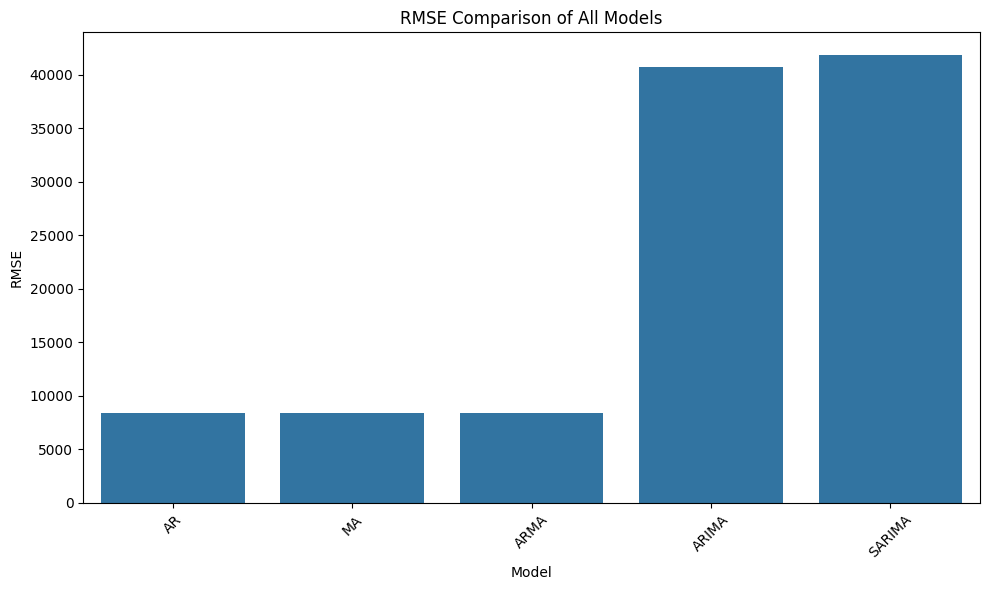

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(data=rmse_df, x='Model', y='RMSE')
plt.title('RMSE Comparison of All Models')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Now Apply DL Models and which one is better for this time series

1 - RNN

2 - LSTM

3 - GRU


In [ ]:


scaler = MinMaxScaler()
data['Scaled'] = scaler.fit_transform(data[['Price']])

def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(seq_len, len(data)):
        X.append(data[i-seq_len:i])
        y.append(data[i])
    return np.array(X), np.array(y)

seq_len = 30
X_all, y_all = create_sequences(data['Scaled'].values, seq_len)

# Align sequence indices to data index
valid_index = data.index[seq_len:]
X_data = pd.DataFrame(index=valid_index)
X_data['X'] = list(X_all)
X_data['y'] = y_all

X_train = np.stack(X_data[X_data.index < '2024-01-01']['X'].values)
y_train = X_data[X_data.index < '2024-01-01']['y'].values
X_test = np.stack(X_data[X_data.index >= '2024-01-01']['X'].values)
y_test = X_data[X_data.index >= '2024-01-01']['y'].values


def build_model(model_type):
    model = Sequential()
    if model_type == 'RNN':
        model.add(SimpleRNN(50, input_shape=(seq_len, 1)))
    elif model_type == 'LSTM':
        model.add(LSTM(50, input_shape=(seq_len, 1)))
    elif model_type == 'GRU':
        model.add(GRU(50, input_shape=(seq_len, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

results = {}
predictions_dl = {}

for model_type in ['RNN', 'LSTM', 'GRU']:
    model = build_model(model_type)
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
    pred = model.predict(X_test)
    pred_inverse = scaler.inverse_transform(pred)
    y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))
    rmse = sqrt(mean_squared_error(y_test_inverse, pred_inverse))
    results[model_type] = rmse
    predictions_dl[model_type] = pred_inverse

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


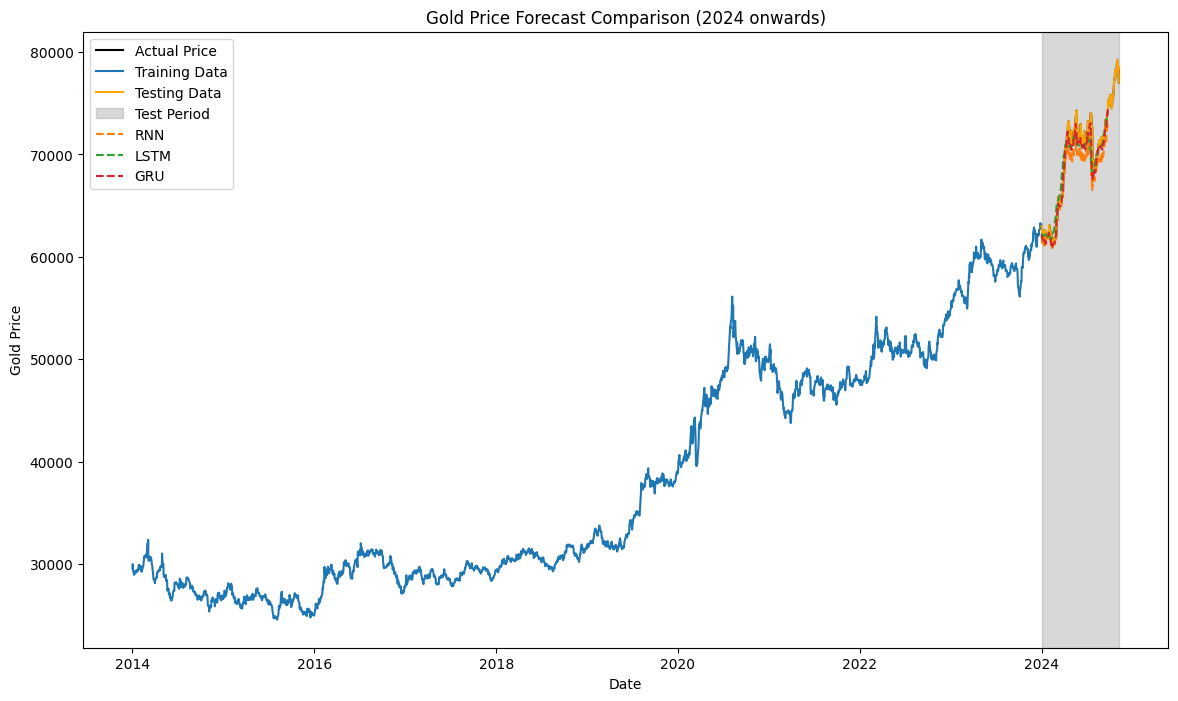

In [ ]:
plt.figure(figsize=(14, 8))
plt.plot(test_data.index, test_data['Price'], label='Actual Price', color='black')
plt.plot(train_data.index, train_data['Price'], label='Training Data')
plt.plot(test_data.index, test_data['Price'], label='Testing Data', color='orange')
plt.axvspan(test_data.index[0], test_data.index[-1], color='gray', alpha=0.3, label='Test Period')


for model_type, predictions in predictions_dl.items():
    plt.plot(test_data.index[:len(predictions)], predictions[::-1], label=model_type, linestyle='--')



plt.xlabel('Date')
plt.ylabel('Gold Price')
plt.title('Gold Price Forecast Comparison (2024 onwards)')
plt.legend()
plt.show()

In [ ]:
rmse_df = pd.DataFrame({
    'Model': ['RNN', 'LSTM', 'GRU'],
    'RMSE': [results['RNN'], results['LSTM'], results['GRU']]
})

rmse_df

,Model,RMSE
0,RNN,1613.975296
1,LSTM,1231.965490
2,GRU,956.391089


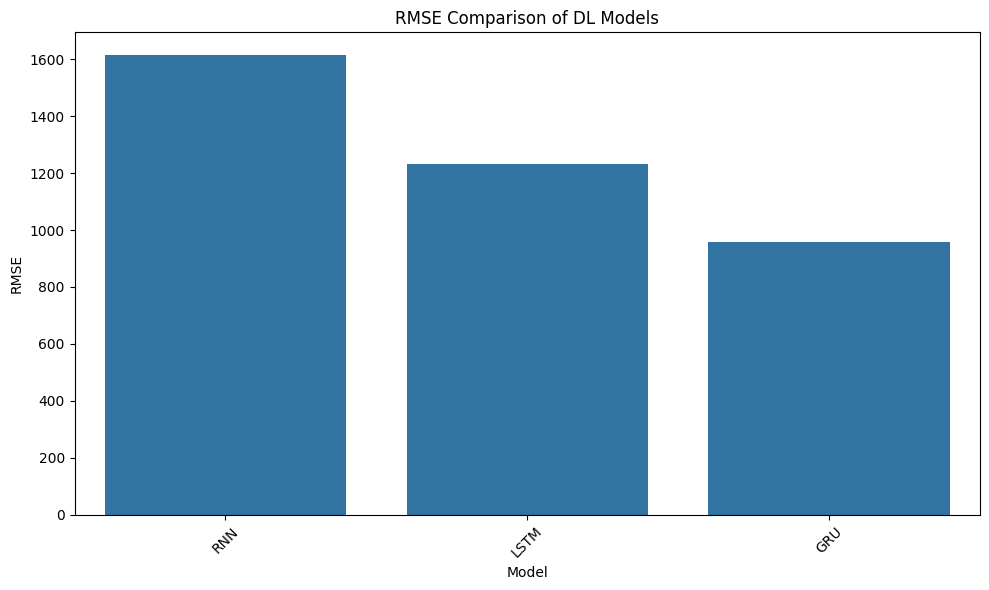

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(data=rmse_df, x='Model', y='RMSE')
plt.title('RMSE Comparison of DL Models')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

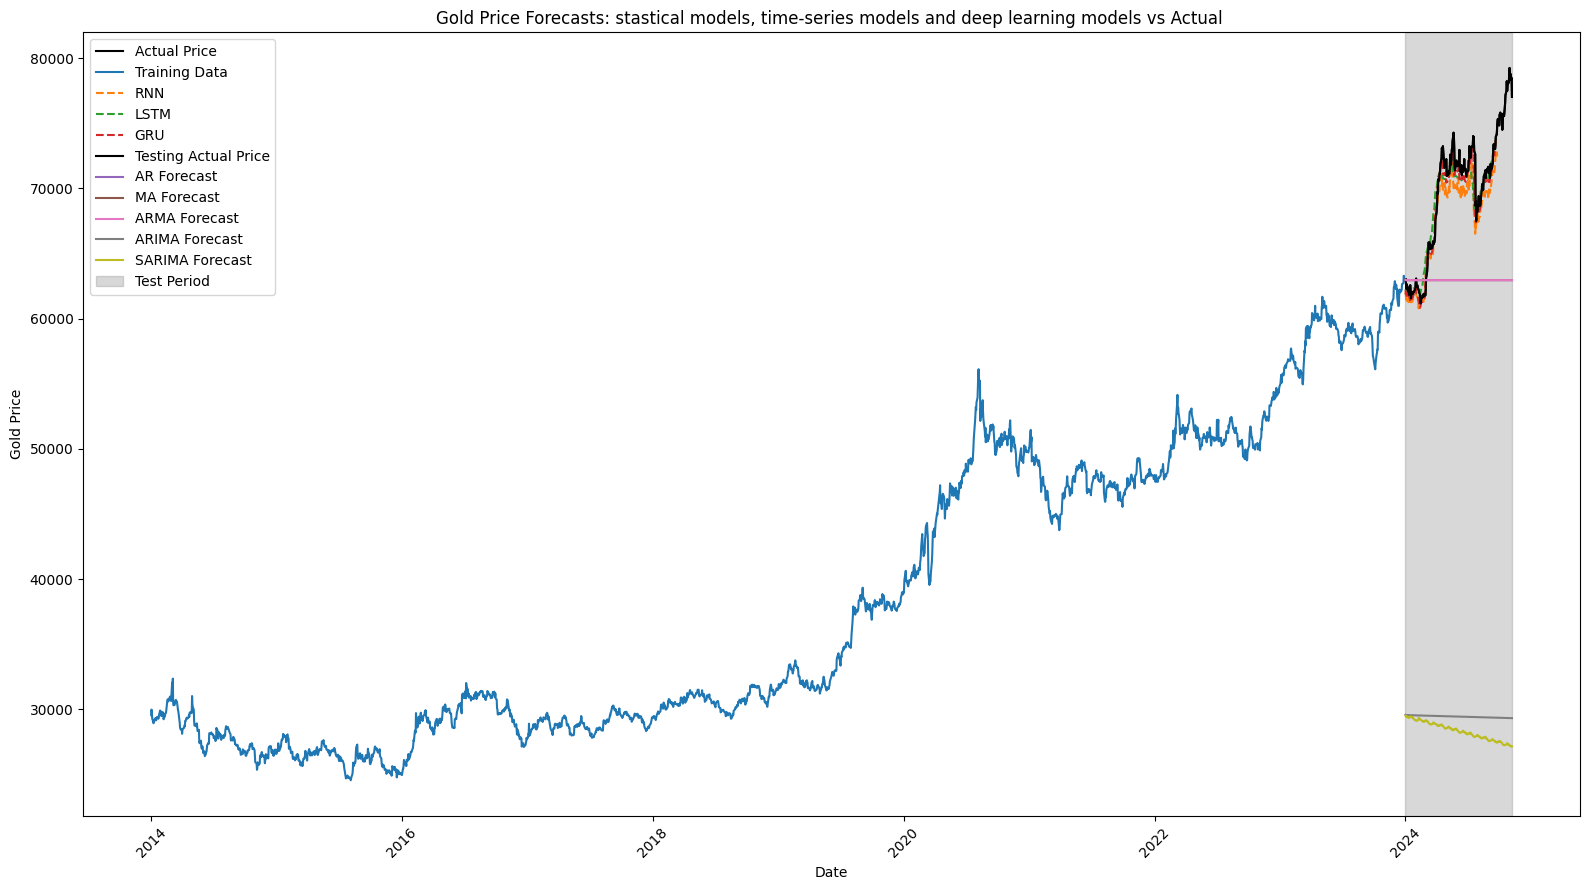

In [ ]:
plt.figure(figsize=(16, 9))
plt.plot(test_data.index, test_data['Price'], label='Actual Price', color='black')
plt.plot(train_data.index, train_data['Price'], label='Training Data')

for model_type, predictions in predictions_dl.items():
  # plt.plot(test_data.index[:len(predictions)], predictions, label=model_type, linestyle='--')
    plt.plot(test_data.index[:len(predictions)], predictions[::-1], label=model_type, linestyle='--')

plt.plot(test_data.index, test_data['Price'], label='Testing Actual Price', color='black')
plt.plot(test_data.index, ar_pred_orig, label='AR Forecast')
plt.plot(test_data.index, ma_pred_orig, label='MA Forecast')
plt.plot(test_data.index, arma_pred_orig, label='ARMA Forecast')
plt.plot(test_data.index, arima_forecast.predicted_mean, label='ARIMA Forecast')
plt.plot(test_data.index, sarima_forecast.predicted_mean, label='SARIMA Forecast')
plt.axvspan(test_data.index[0], test_data.index[-1], color='gray', alpha=0.3, label='Test Period')
plt.title("Gold Price Forecasts: stastical models, time-series models and deep learning models vs Actual ")
plt.xlabel("Date")
plt.ylabel("Gold Price")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




In [ ]:
rmse_df = pd.DataFrame({
    'Model': ['Mean', 'Last 30 Mean', 'Naive Seasonal','AR','MA','ARMA','ARIMA', 'SARIMA', 'RNN', 'LSTM', 'GRU'],
    'RMSE': [
         rmse_mean, rmse_last_30, rmse_naive_seasonal,
        math.sqrt(mean_squared_error(test_data['Price'], ar_pred_orig)),
        math.sqrt(mean_squared_error(test_data['Price'], ar_pred_orig)),
        math.sqrt(mean_squared_error(test_data['Price'], ar_pred_orig)),
        math.sqrt(mean_squared_error(test_data['Price'], arima_forecast.predicted_mean)),
        math.sqrt(mean_squared_error(test_data['Price'], sarima_forecast.predicted_mean)),
        results['RNN'], results['LSTM'], results['GRU']
    ]
})

rmse_df

,Model,RMSE
0,Mean,31979.194117
1,Last 30 Mean,40721.526649
2,Naive Seasonal,11270.451186
3,AR,8405.498547
4,MA,8405.498547
5,ARMA,8405.498547
6,ARIMA,40703.601935
7,SARIMA,41866.452982
8,RNN,1620.785268
9,LSTM,1322.425636


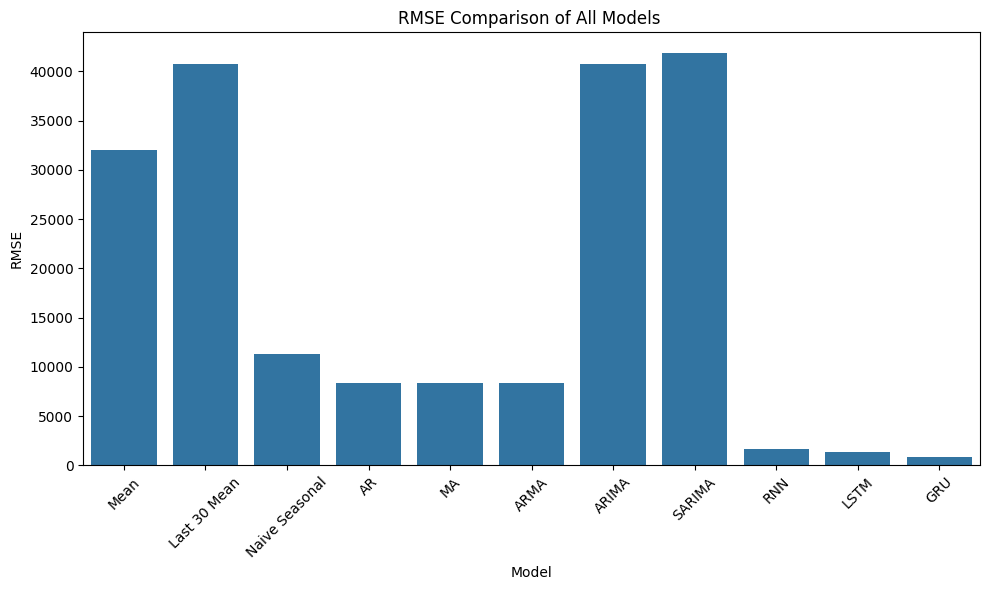

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(data=rmse_df, x='Model', y='RMSE')
plt.title('RMSE Comparison of All Models ')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
